In [1]:
# SETUP: To import all packages. 

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
# INTERFACE: To determine the HSV of a color from a picture.  

filepath = 'Sample1.png'

# Read the image
img = cv2.imread(filepath)
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
scaling_factor = 0.4 
resized_img = cv2.resize(img, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_LINEAR)
resized_result = cv2.resize(resized_img, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_LINEAR)

# Create a window
cv2.namedWindow('Segmentation')

# Initialize HSV range with some default values
lower_range = np.array([0, 0, 0])
upper_range = np.array([255, 255, 255])

# Callback function for trackbars
def update_range(x):
    pass
# Create trackbars for HSV range
cv2.createTrackbar('Hue Min', 'Segmentation', 0, 255, update_range)
cv2.createTrackbar('Saturation Min', 'Segmentation', 0, 255, update_range)
cv2.createTrackbar('Value Min', 'Segmentation', 0, 255, update_range)
cv2.createTrackbar('Hue Max', 'Segmentation', 255, 255, update_range)
cv2.createTrackbar('Saturation Max', 'Segmentation', 255, 255, update_range)
cv2.createTrackbar('Value Max', 'Segmentation', 255, 255, update_range)

while True:
    # Get current trackbar positions
    lower_range[0] = cv2.getTrackbarPos('Hue Min', 'Segmentation')
    lower_range[1] = cv2.getTrackbarPos('Saturation Min', 'Segmentation')
    lower_range[2] = cv2.getTrackbarPos('Value Min', 'Segmentation')
    upper_range[0] = cv2.getTrackbarPos('Hue Max', 'Segmentation')
    upper_range[1] = cv2.getTrackbarPos('Saturation Max', 'Segmentation')
    upper_range[2] = cv2.getTrackbarPos('Value Max', 'Segmentation')

    # Apply mask 
    mask = cv2.inRange(hsv_img, lower_range, upper_range)
    result = cv2.bitwise_and(img, img, mask=mask)

    # Resize the images with a specified interpolation method
    resized_img = cv2.resize(img, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_LINEAR)
    resized_result = cv2.resize(result, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_LINEAR)

    # Display the images
    cv2.imshow('Segmentation', np.hstack([resized_img, resized_result]))

    # Check for the 'ESC' key to exit
    if cv2.waitKey(1) == 27:
        break

# Release resources
cv2.destroyAllWindows()


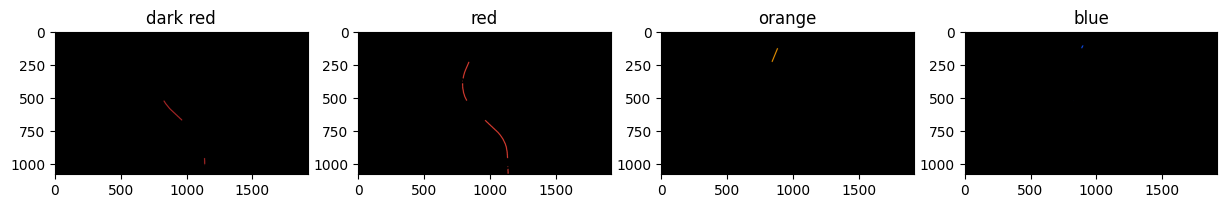

(8119, 1948, 5113, 867, 191)


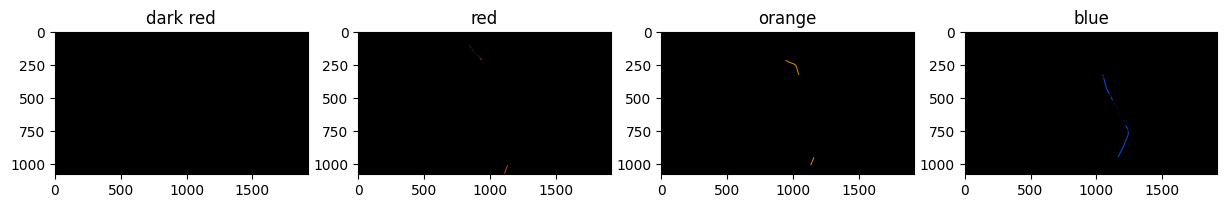

(5442, 0, 731, 1515, 3196)


In [5]:
# MASK FUNCTION: Function to create and apply masks on images. 

"""
INPUTs: 
    1. filepath     : path to the screenshot
OUTPUTs:
    1. pixels       : total number of scanned pixels 
    2. cat_4        : category 4 traffic pixels (worst)
    3. cat_3        : category 3 traffic pixels (worse)
    4. cat_2        : category 2 traffic pixels (okay)
    5. cat_1        : category 1 traffic pixels (good)
"""

def pixel_counter(filepath, print_plot=False): 
    dict_colors = {
        'dark red': {'lower': (0, 197, 189), 'upper': (2, 198, 192)},
        'red': {'lower': (0, 199, 244), 'upper': (2, 200, 245)},
        'orange': {'lower': (18, 254, 255), 'upper': (20, 255, 255)},
        'blue': {'lower': (110, 239, 254), 'upper': (112, 241, 255)}  
    }
    colors = list(dict_colors.keys())

    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    img = cv2.imread(filepath)
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    dict_results = {}
    for idx, color in enumerate(colors):
        lower_range = dict_colors[color]['lower']
        upper_range = dict_colors[color]['upper']

        mask = cv2.inRange(hsv_img, lower_range, upper_range)
        result = cv2.bitwise_and(img, img, mask=mask)

        axs[idx].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        axs[idx].set_title(color)

        pixel_count = np.count_nonzero(mask)
        dict_results[color] = pixel_count
    if print_plot:
        plt.show()
    plt.clf()
    plt.close()

    cat_4, cat_3, cat_2, cat_1 = dict_results['dark red'], dict_results['red'], dict_results['orange'], dict_results['blue']
    pixels = cat_4 + cat_3 + cat_2 + cat_1

    return pixels, cat_4, cat_3, cat_2, cat_1

# Sample Implementation
print(pixel_counter('Sample.png', print_plot=True))
print(pixel_counter('Sample1.png', print_plot=True))

In [6]:
# EXECUTION

csv_filenames = os.listdir('Downloads\\CSV')

for csv_filename in csv_filenames:
    csv_folderpath = f"Downloads\\CSV\\{csv_filename}"
    df = pd.read_csv(csv_folderpath)

    count = 0
    for i in range(len(df)):
        # Construct filepath for the i-th entry
        date = f"{df.iloc[i]['Date']}"
        depart_time = df.iloc[i]['Time'].replace(':', '.').replace('am', 'AM')
        filename = df.iloc[i]['Filename']
        filepath = f"Downloads\\{date} {depart_time}\\{filename}"

        # Run pixel counter function for the i-th entry.
        pixels, cat_4, cat_3, cat_2, cat_1 = pixel_counter(filepath)

        # Store results in the dataframe
        df.loc[i, 'Pixels'] = pixels
        df.loc[i, 'Cat 4'] = cat_4
        df.loc[i, 'Cat 3'] = cat_3
        df.loc[i, 'Cat 2'] = cat_2
        df.loc[i, 'Cat 1'] = cat_1

        # Print progress bar
        count += 1
        progress = round(100 * (count) / (len(df)), 2)
        print(f"\rProgress: {progress} %  Rows processed: {count}", end='', flush=True)

    # Save the dataframe into CSV
    download_filename = f"RESULTS - {csv_filename}"
    download_filepath = f"Downloads\\CSV\\{download_filename}"
    df.to_csv(download_filepath)
    del df

    print("")
    print(f"All screenshots processed and results saved as a csv with filename: {download_filename}")

In [9]:
# MERGING RESULTS

results = [
    'RESULTS - 01-Sep-23 8.00 AM.csv', 
    'RESULTS - 01-Sep-23 8.05 AM.csv', 
    'RESULTS - 01-Sep-23 8.10 AM.csv', 
    'RESULTS - 01-Sep-23 8.15 AM.csv', 
    'RESULTS - 01-Sep-23 8.20 AM.csv', 
    'RESULTS - 01-Sep-23 8.25 AM.csv', 
    'RESULTS - 01-Sep-23 8.30 AM.csv', 
    'RESULTS - 01-Sep-23 8.35 AM.csv', 
    'RESULTS - 01-Sep-23 8.40 AM.csv', 
    'RESULTS - 01-Sep-23 8.45 AM.csv', 
    'RESULTS - 01-Sep-23 8.50 AM.csv', 
    'RESULTS - 01-Sep-23 8.55 AM.csv', 
    'RESULTS - 01-Sep-23 9.00 AM.csv', 
]

dc = {}

count = 0
for result in results:
    path = f"Downloads//CSV//{result}"
    dc[count] = pd.read_csv(path)
    count += 1

list_results = [dc[0], dc[1], dc[2], dc[3], dc[4], dc[5], dc[6], dc[7], dc[8], dc[9], dc[10], dc[11], dc[12]]

df_combined = pd.concat(list_results)

df_combined.to_csv(f"Downloads//CSV//Results Combined.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'Downloads//CSV//RESULTS - 01-Sep-23 8.00 AM.csv'